In [5]:
from main import load_mnist
import torch
import torchvision

0.12497392296791077


Text(0.5, 1.0, 'Custom weights')

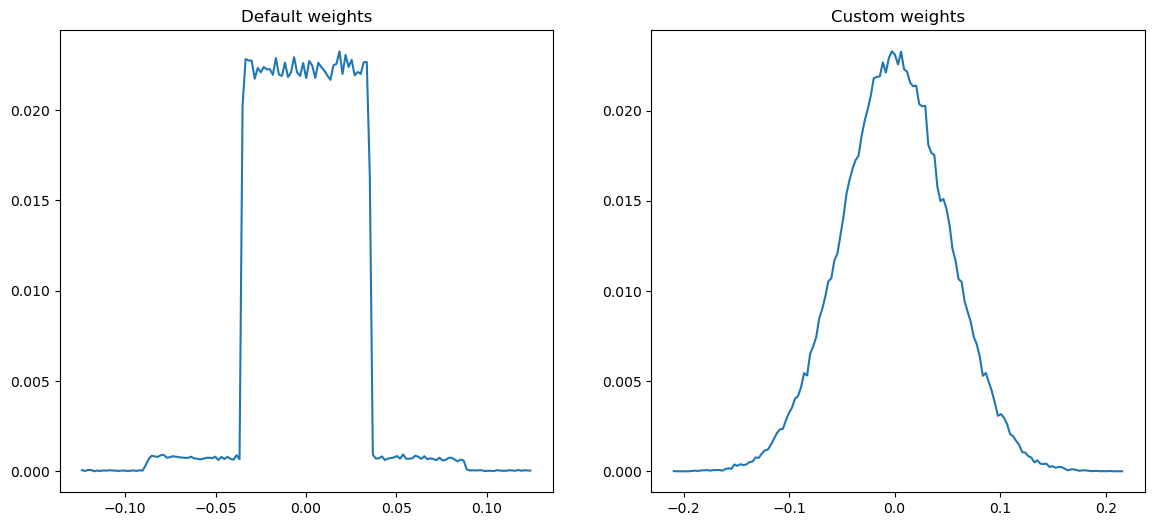

In [7]:
from deterministic.vanilla_net import VanillaNetLinear
from probabilistic.distribution_utils import to_discrete_distribution
import numpy as np
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda_available else 'cpu')
vanilla_net = VanillaNetLinear()
# Get all the initial weights and plot their distribution
default_weights = np.array([])
for param in vanilla_net.named_parameters():
    if 'weight' in param[0]:
        w = param[1].view(-1)
        default_weights = np.concatenate((default_weights, w.detach().numpy()), axis=None)
print(max(default_weights))

custom_weights = np.array([])
for param in vanilla_net.named_parameters():
    if 'weight' in param[0]:
        init_vals = torch.normal(mean=0.0, std=0.05, size=tuple(param[1].shape)).to(device)
        param[1].data = torch.nn.parameter.Parameter(init_vals)
        w = param[1].view(-1)
        custom_weights = np.concatenate((custom_weights, w.detach().numpy()), axis=None)

domain_values_default, range_values_default = to_discrete_distribution(default_weights)
domain_values_custom, range_values_custom = to_discrete_distribution(custom_weights)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(domain_values_default, range_values_default)
#axs[0].hist(default_weights, bins=100)
axs[0].set_title('Default weights')
axs[1].plot(domain_values_custom, range_values_custom)
#axs[1].hist(custom_weights, bins=100)
axs[1].set_title('Custom weights')

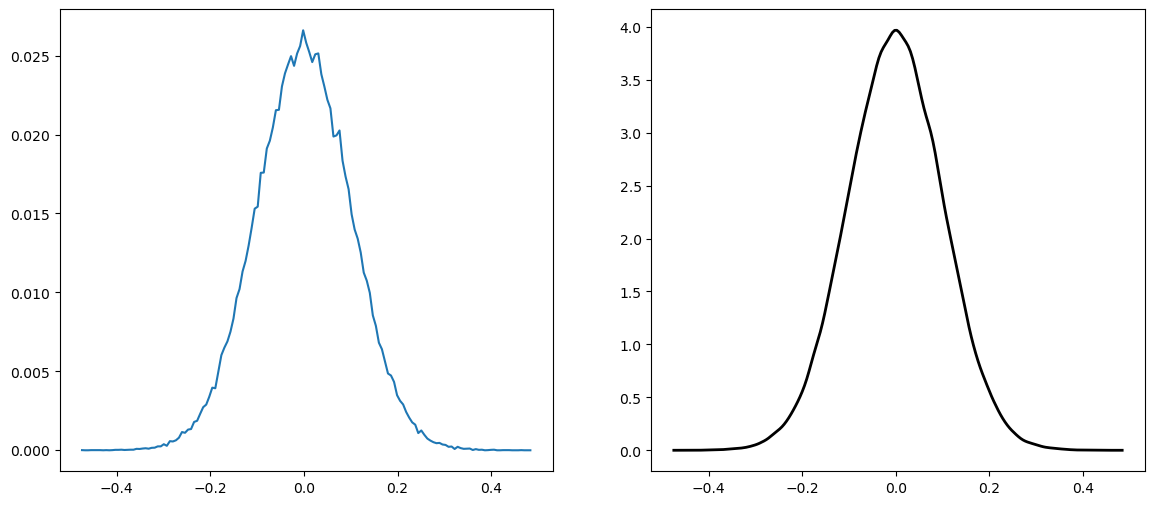

In [8]:
from scipy.stats import gaussian_kde

# Now in a similar way plot the weights distribution after training
trained_vanilla_net = VanillaNetLinear()
trained_vanilla_net.load_state_dict(torch.load('vanilla_network.pt'))
trained_vanilla_net.to(device)
trained_vanilla_net.eval()


optimized_weights = np.array([])
for param in trained_vanilla_net.named_parameters():
    if 'weight' in param[0]:
        w = param[1].view(-1)
        optimized_weights = np.concatenate((optimized_weights, w.detach().numpy()), axis=None)

# first fit a distribution to the data
density = gaussian_kde(optimized_weights)

domain_values_optimized, range_values_optimized = to_discrete_distribution(optimized_weights)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(domain_values_optimized, range_values_optimized)
# axs[0].hist(optimized_weights, bins=500)
cts_domain = np.linspace(np.min(domain_values_optimized), np.max(domain_values_optimized), 200)
axs[1].plot(cts_domain, density(cts_domain), 'k', linewidth=2)

In [9]:
import probabilistic.models as models
import probabilistic.hamiltonian as ham
import probabilistic.pipeline as pipeline
import importlib
importlib.reload(models)
importlib.reload(ham)
importlib.reload(pipeline)
from probabilistic.models import WeightModel
from probabilistic.hamiltonian import Hamiltonian
from probabilistic.pipeline import hmc, dp_hmc

num_variational_params = 2
w_prior_mean, w_prior_cov = torch.zeros(num_variational_params), torch.eye(num_variational_params)
weight_probabilistic_model = WeightModel(prior_mean=w_prior_mean, prior_variance=w_prior_cov, low=-0.5, high=0.5)
w_prior = weight_probabilistic_model.uniform_prior
nn_likelihood = weight_probabilistic_model.parameterized_gaussian_likelihood

momentum_variances = torch.ones(num_variational_params) # mean and variance in our case
hamiltonian = Hamiltonian(w_prior, nn_likelihood, momentum_variances, torch.tensor(optimized_weights))

variational_params_samples = dp_hmc(hamiltonian)
variational_params_samples

[tensor([0.1266, 0.5491], grad_fn=<SubBackward0>),
 tensor([0.1265, 0.5491], grad_fn=<SubBackward0>),
 tensor([0.1264, 0.5491], grad_fn=<SubBackward0>),
 tensor([0.1263, 0.5491], grad_fn=<SubBackward0>),
 tensor([0.1263, 0.5491], grad_fn=<SubBackward0>),
 tensor([0.1262, 0.5491], grad_fn=<SubBackward0>),
 tensor([0.1261, 0.5491], grad_fn=<SubBackward0>),
 tensor([0.1260, 0.5490], grad_fn=<SubBackward0>),
 tensor([0.1259, 0.5490], grad_fn=<SubBackward0>),
 tensor([0.1258, 0.5490], grad_fn=<SubBackward0>),
 tensor([0.1258, 0.5490], grad_fn=<SubBackward0>),
 tensor([0.1257, 0.5490], grad_fn=<SubBackward0>),
 tensor([0.1256, 0.5490], grad_fn=<SubBackward0>),
 tensor([0.1255, 0.5490], grad_fn=<SubBackward0>),
 tensor([0.1254, 0.5489], grad_fn=<SubBackward0>),
 tensor([0.1253, 0.5489], grad_fn=<SubBackward0>),
 tensor([0.1253, 0.5489], grad_fn=<SubBackward0>),
 tensor([0.1252, 0.5489], grad_fn=<SubBackward0>),
 tensor([0.1251, 0.5489], grad_fn=<SubBackward0>),
 tensor([0.1250, 0.5489], grad_

In [10]:
samples = [(float(tns[0]), float(tns[1])) for _, tns in enumerate(variational_params_samples)]
mus, sigma2s = zip(*samples)
mus, sigma2s = np.array(mus), np.array(sigma2s)
print(mus, sigma2s)
# compute the mean and variance uniased estimates
mean_estimate = np.mean(mus)
sigma2_estimate = np.sum(sigma2s) / (len(sigma2s) - 1) # unbiased estimate

mean_estimate, sigma2_estimate

[0.12658753 0.12650417 0.12642081 ... 0.00574593 0.0057521  0.00575826] [0.54914337 0.54912859 0.54911381 ... 0.66017455 0.66043597 0.6606974 ]


(0.02305919685144974, 0.6099763332953424)

0.026606462485345837


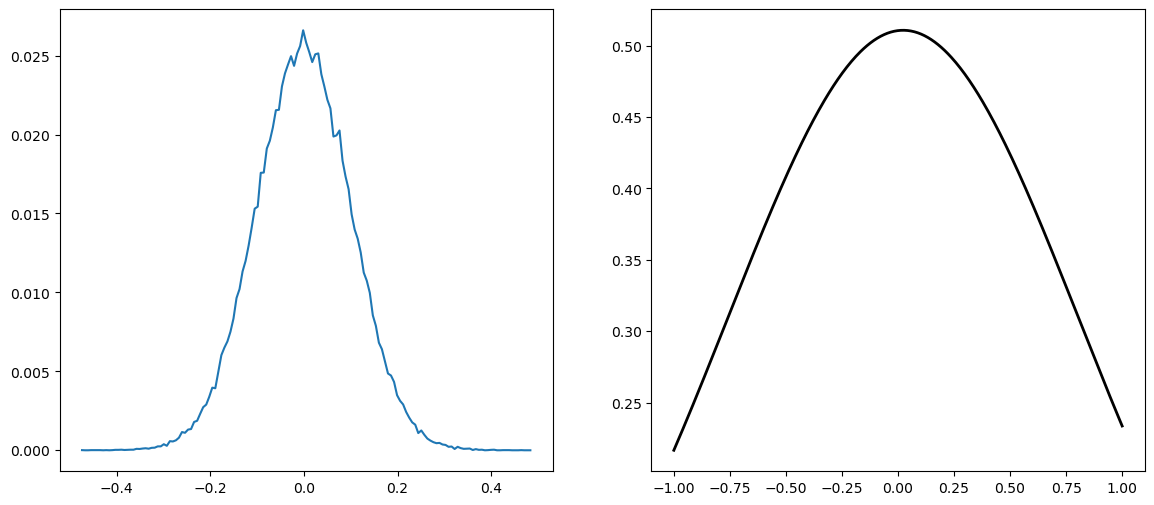

In [11]:
# sample from normal distribution with the above mean and variance
from scipy.stats import norm
# hmc_weights = np.random.normal(loc=mean_estimate, scale=np.sqrt(sigma2_estimate), size=optimized_weights.shape)
print(max(range_values_optimized))
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(domain_values_optimized, range_values_optimized)
# axs[0].hist(optimized_weights, bins=500)
cts_domain = np.linspace(-1, 1, 400)
axs[1].plot(cts_domain, norm.pdf(cts_domain, mean_estimate, np.sqrt(sigma2_estimate)), 'k', linewidth=2)

In [17]:
for param in vanilla_net.named_parameters():
    if 'weight' in param[0]:
        print(param[0])
        print(param[1].shape)
        print(torch.prod(torch.tensor(param[1].shape)))

linear.0.weight
torch.Size([128, 784])
tensor(100352)
linear.2.weight
torch.Size([64, 128])
tensor(8192)
linear.4.weight
torch.Size([10, 64])
tensor(640)


In [23]:
import probabilistic.bnn as bnn
import probabilistic.models as models
import probabilistic.hamiltonian as ham
import probabilistic.pipeline as pipeline
import importlib
importlib.reload(models)
importlib.reload(ham)
importlib.reload(pipeline)
importlib.reload(bnn)
from probabilistic.models import WeightModel
from probabilistic.hamiltonian import Hamiltonian
from probabilistic.pipeline import hmc_bnn
from probabilistic.bnn import VanillaBNN, BNN
from dataset_utils import load_mnist


# First create the BNN
vanilla_bnn = VanillaBNN()
train_data, test_data = load_mnist()
# should broadcast to the correct shape
w_prior_mean, w_prior_cov = torch.zeros(1), torch.eye(1)
weight_probabilistic_model = WeightModel(prior_mean=w_prior_mean, prior_variance=w_prior_cov)
w_prior = weight_probabilistic_model.log_gaussian_prior
nn_likelihood = weight_probabilistic_model.nn_empirical_gaussian_likelihood

momentum_variances = torch.ones(1)
hamiltonian = Hamiltonian(w_prior, nn_likelihood, momentum_variances, train_data, net = vanilla_bnn)

variational_params_samples = hmc_bnn(hamiltonian)
variational_params_samples

[]